# Linear Regression Time Series Prediction
Télécharger les données Train.csv depuis la plateforme Zindi. Puis sur votre gauche clickez sur Files, et faite un drag and drop du fichier.

Commençons par observer les variables du dataset. Mais avant on aura besoin de travailler sur Tensorflow 2

In [1]:
!pip install tensorflow-gpu==2.0.0-beta0

     |████████████████████████████████| 348.9MB 75kB/s 
     |████████████████████████████████| 3.1MB 53.4MB/s 
     |████████████████████████████████| 501kB 56.6MB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
print(tf.__version__)

2.0.0-beta0


In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


training_data_url = "https://raw.githubusercontent.com/ummisco-deep-learning/Soil_Moisture_Challenge/master/data/Train.csv"
train = pd.read_csv(training_data_url)
columns = train.keys()

print(columns)


Index(['timestamp', 'Soil humidity 1', 'Irrigation field 1', 'Soil humidity 2',
       'Irrigation field 2', 'Soil humidity 3', 'Irrigation field 3',
       'Soil humidity 4', 'Irrigation field 4', 'Air temperature (C)',
       'Air humidity (%)', 'Pressure (KPa)', 'Wind speed (Km/h)',
       'Wind gust (Km/h)', 'Wind direction (Deg)'],
      dtype='object')


In [0]:
# Let's work with np array as it might make things easier

slot1 = np.array(train["Soil humidity 1"])
slot2 = np.array(train["Soil humidity 2"])
slot3 = np.array(train["Soil humidity 3"])
slot4 = np.array(train["Soil humidity 4"])

irrigation1 = np.array(train["Irrigation field 1"])
irrigation2 = np.array(train["Irrigation field 2"])
irrigation3 = np.array(train["Irrigation field 3"])
irrigation4 = np.array(train["Irrigation field 4"])

In [0]:
mask1_not_na = np.isnan(slot1)
slot1 = slot1[~mask1_not_na]

mask2_not_na = np.isnan(slot2)
slot2 = slot2[~mask2_not_na]


mask3_not_na = np.isnan(slot3)
slot3 = slot3[~mask3_not_na]

mask4_not_na = np.isnan(slot4)
slot4 = slot4[~mask4_not_na]



# TODO: Check that there are no nan in between 

That's fine. Now let's create a windowed dataset. We'll split it up in a training/test set later.

So let's say we use 30 set of 5 minutes to predict the next value. We are going to do it this way.

In [0]:
def windowed_dataset(data, window_size, batch_size):
  # Transform the pandas Dataframe to a tensorflow data
  dataset = tf.data.Dataset.from_tensor_slices(data)  

  # Partition the dataset with element of sizw window, drop the last one if its size is < window
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)  
  # Each set of window+1 element is fit into a list
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  # We separate the window first from the last element [w1, ..., wn-1][wn]
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))  

  # Finally come batching which make learning faster
  dataset = dataset.batch(batch_size)
  return dataset


In [0]:
# Let's work with one dataset, we choose slot2 
data = slot2

# We find when to split our data into training/validation .
train_time = int(len(data) * .7)

# We need this one to get the index of each dataset, it will make sense at the next plot
time = np.arange(len(data))

In [0]:
time_train = time[:train_time]
x_train = data[:train_time]
time_valid = time[train_time:]
x_valid = data[train_time:]

Text(0.5, 1.0, 'Training set')

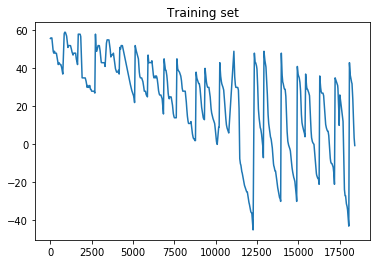

In [11]:
plt.plot(time_train, x_train)
plt.title("Training set")

Text(0.5, 1.0, 'Validation set')

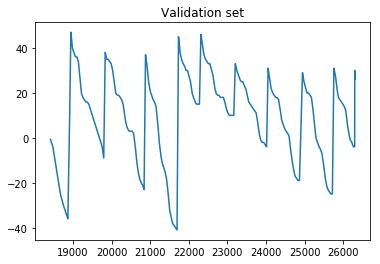

In [12]:
plt.plot(time_valid, x_valid)
plt.title("Validation set")

In [0]:
window_size=30
batch_size=16
training_set = windowed_dataset(x_train, window_size, batch_size)

In [0]:
inputs = Input(shape=(window_size,))
predictions = Dense(1)(inputs)
model = Model(inputs, predictions)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [15]:
model.fit(training_set, epochs=10, verbose=1)

Epoch 1/10
1149/1149 [==============================] - 9s 8ms/step - loss: 76.0901
Epoch 2/10
1149/1149 [==============================] - 4s 4ms/step - loss: 1.0718
Epoch 3/10
1149/1149 [==============================] - 4s 4ms/step - loss: 0.9037
Epoch 4/10
1149/1149 [==============================] - 4s 4ms/step - loss: 0.8001
Epoch 5/10
1149/1149 [==============================] - 4s 4ms/step - loss: 0.7166
Epoch 6/10
1149/1149 [==============================] - 4s 4ms/step - loss: 0.6489
Epoch 7/10
1149/1149 [==============================] - 4s 4ms/step - loss: 0.5936
Epoch 8/10
1149/1149 [==============================] - 4s 4ms/step - loss: 0.5481
Epoch 9/10
1149/1149 [==============================] - 4s 4ms/step - loss: 0.5104
Epoch 10/10
1149/1149 [==============================] - 4s 4ms/step - loss: 0.4787


In [0]:
# We predict for the entire dataset
forecast = []
for time in range(len(slot2) - window_size):
  forecast.append(model.predict(slot2[time : time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

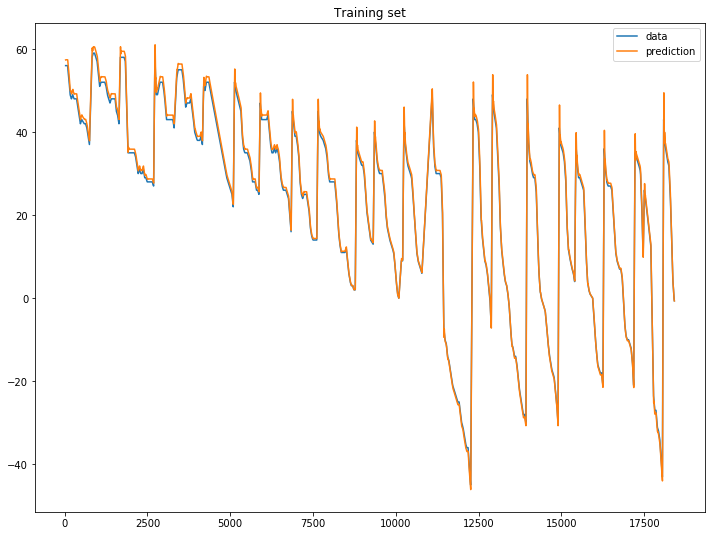

In [26]:
plt.figure(figsize=(12,9))
plt.plot(time_train[window_size:], data[window_size:train_time], label="data")
plt.plot(time_train[window_size:], results[:train_time-window_size], label="prediction")
plt.title("Training set")
plt.legend()

In [24]:
# Loss on the training set
np.sqrt(np.mean(np.power((data[window_size:train_time]-results[:train_time-window_size]),2)))

1.0636935454210799

In [0]:
# We predict for the entire dataset
forecast = []
for time in range(len(slot2) - window_size):
  forecast.append(model.predict(slot2[time : time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

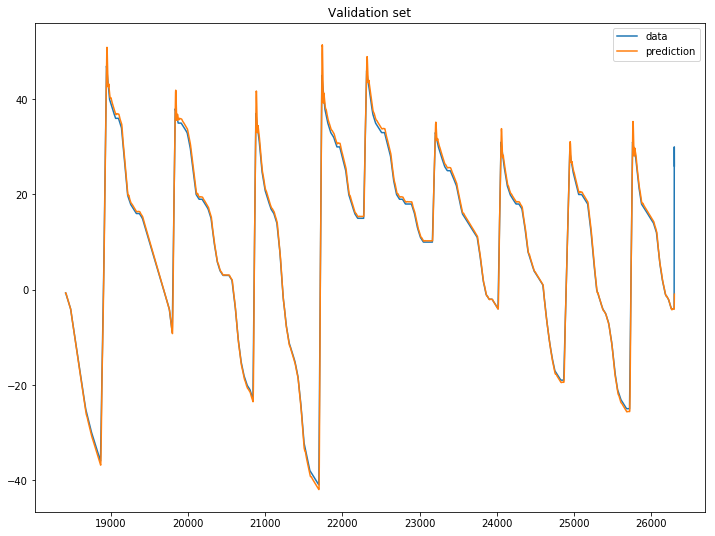

In [27]:
plt.figure(figsize=(12,9))
plt.plot(time_valid, data[train_time:], label="data")
plt.plot(time_valid, results[train_time-window_size:], label="prediction")
plt.title("Validation set")
plt.legend()

In [0]:
def autoregressive(num_points, window_size, init):
  predictions = np.zeros(num_points)
  predictions[:window_size] = init
  for i in range(num_points-window_size-1):
    pred = model.predict(predictions[i:i+window_size][np.newaxis])
    predictions[i+window_size+1] = pred
  return predictions

In [0]:
val_pred = autoregressive(1000, window_size, prediction_training[-window_size:])

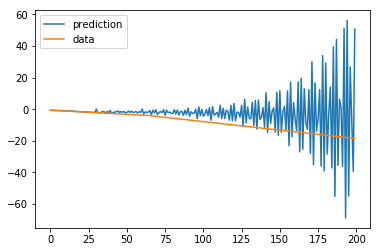

In [32]:
plt.plot(val_pred[:200],label="prediction")
plt.plot(x_valid[:200], label="data")
plt.legend()